# Affinity Water Test


In [36]:
# Import necessary packages for data exploration
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx


#Import packags for model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

Access the data from the affinity water test link that has been downloaded into a .csv file using pandas df.


In [23]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Affinity_Water_Night_flow_Monitoring.csv')
# Get column names for data usage
print(df.columns)

# Generate summary statistics
summary_stats = df.describe(include='all')
print(summary_stats)
print("")

# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display the columns and the count of missing values
print("Missing values in the dataset:\n", missing_values)

Index(['DATA_SOURCE', 'DATETIME_STAMP', 'DMA_ID', 'CENTROID_X', 'CENTROID_Y',
       'ACTUAL_MIN_NIGHT_FLOW', 'MIN_NIGHT_FLOW', 'UNITS', 'ObjectId'],
      dtype='object')
           DATA_SOURCE    DATETIME_STAMP   DMA_ID     CENTROID_X  \
count           974934            974934   974934  974934.000000   
unique               1              1095      989            NaN   
top     Affinity Water  20/12/2023 00:00  AW_2280            NaN   
freq            974934               945     1095            NaN   
mean               NaN               NaN      NaN      -0.184905   
std                NaN               NaN      NaN       0.481438   
min                NaN               NaN      NaN      -0.769312   
25%                NaN               NaN      NaN      -0.456611   
50%                NaN               NaN      NaN      -0.360623   
75%                NaN               NaN      NaN      -0.172561   
max                NaN               NaN      NaN       1.387540   

           

### Initial Thoughts

There are only 2 columns within this dataset that jump out to me here in terms of raw data interpretation from the summary statistics alone: ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW. 

- In the ACTUAL_MIN_NIGHT_FLOW column, we see that the minimum values are in the negatives, which is interesting as my initial thoughts are that water flow should be detailed in positive values only. We also see that we have missing values here.
- There’s a significant discrepancy between the min and max values in both ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW columns, indicating potential outliers or data entry errors. The comparison between the actual flow and the expected (minimum) flow could provide useful insights into inefficiencies, leaks, or anomalies within the water distribution network.

I want to explore more into not only the flow rate and the missing values, but also the flow rate with respect to the centroid values and the DMA IDs, as we can determine if the unexpected and faulty flow rates are specific to certain areas.

### Diving into the data

In [6]:
# save the interesting columns into dfs to plot and analyze
actual_min_flow = df['ACTUAL_MIN_NIGHT_FLOW']
min_night_flow = df['MIN_NIGHT_FLOW']
x_coords = df['CENTROID_X']
y_coords = df['CENTROID_Y']
dma_ids = df['DMA_ID']

We can assess how well the actual flow aligns with the expected flow by plotting our actual minimum night time flow values with out average minimum night time flow values. Points that fall far from the 1:1 line (i.e., where ACTUAL_MIN_NIGHT_FLOW ≈ MIN_NIGHT_FLOW) highlight significant deviations.

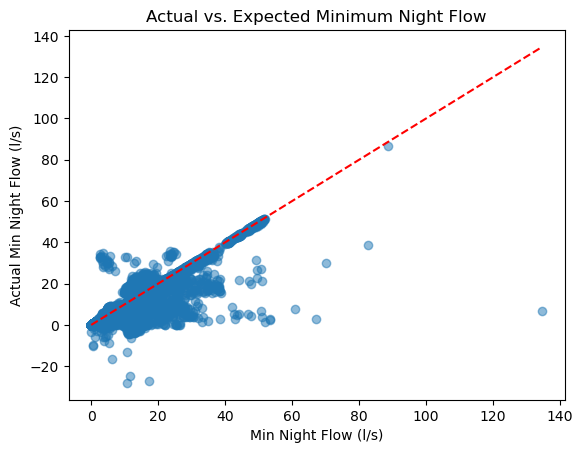

In [46]:
# Plot the data MIN_NIGHT_FLOW vs ACTUAL_MIN_NIGHT_FLOW
plt.scatter(df['MIN_NIGHT_FLOW'], df['ACTUAL_MIN_NIGHT_FLOW'], alpha=0.5)
plt.plot([0, max(df['MIN_NIGHT_FLOW'])], [0, max(df['MIN_NIGHT_FLOW'])], color='red', linestyle='--')
plt.xlabel('Min Night Flow (l/s)')
plt.ylabel('Actual Min Night Flow (l/s)')
plt.title('Actual vs. Expected Minimum Night Flow')
plt.show()

Based on the above, we see that a large portion of the data is not linear, which could indicate operational inefficiencies or potential anomalies.

I want to visualize the raw values for the actual minimum night time flow so we can see the distribution of both positive and negative values. Maybe we can identify some significant information.

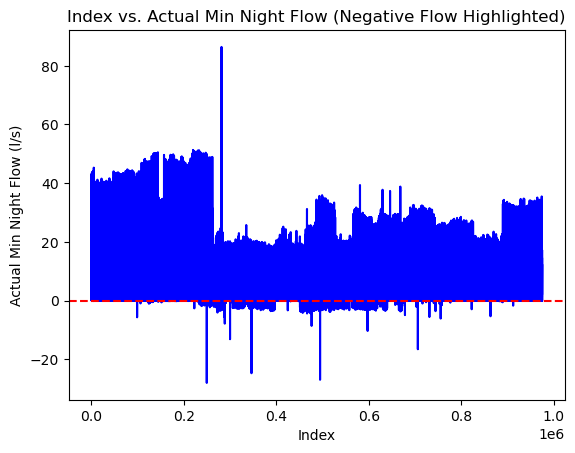

In [47]:
# Plot the actual minimum night time flow in terms of index number
plt.plot(df.index, df['ACTUAL_MIN_NIGHT_FLOW'], color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Actual Min Night Flow (l/s)')
plt.title('Index vs. Actual Min Night Flow (Negative Flow Highlighted)')
plt.show()

We can see from the above that there is a portion of the data that resides within the negative space of the flow rate. Let's determine how much of the data is negative.

In [48]:
# Count the number of times that the values for both are in the negative
# Set the threshold to be 0 so we can find the number of times the values are in the negative
threshold = 0

# Count the number of times ACTUAL_MIN_NIGHT_FLOW goes below the threshold
negative_count_actual_flow = (df['ACTUAL_MIN_NIGHT_FLOW'] < threshold).sum()
positive_count_actual_flow = (df['ACTUAL_MIN_NIGHT_FLOW'] >= threshold).sum()

print(f"The number of times ACTUAL_MIN_NIGHT_FLOW is below {threshold}: {negative_count_actual_flow}")
print(f"The number of times ACTUAL_MIN_NIGHT_FLOW is above or equal to {threshold}: {positive_count_actual_flow}")

The number of times ACTUAL_MIN_NIGHT_FLOW is below 0: 605
The number of times ACTUAL_MIN_NIGHT_FLOW is above or equal to 0: 974255


We see that there is a noticeable amount of cases in which the flow of the water is negative. The number of times that the actual minimum night time flow value value is negative is 605, versus the 974255 values that are positive. Let's set up our data so we can check to see if these negative cases are related geographically. While we're doing that, let's see if we can find any missing values to determine their relationship with location as well.

In [50]:
# I want to make a df in which we only include the rows of data in which the ACTUAL_MIN_NIGHT_FLOW values are in the negative.
negative_flow_df = df[df['ACTUAL_MIN_NIGHT_FLOW'] < 0]

# I want to do the same with the missing data as well to see if we can find any patterns there! So, filter for DMAs with missing ACTUAL_MIN_NIGHT_FLOW
missing_flow_df = df[df['ACTUAL_MIN_NIGHT_FLOW'].isnull()]

print(negative_flow_df)
print("")
print(missing_flow_df)

           DATA_SOURCE    DATETIME_STAMP   DMA_ID  CENTROID_X  CENTROID_Y  \
5635    Affinity Water  07/01/2021 00:00  AW_3502   -0.380053   51.895651   
9876    Affinity Water  12/01/2021 00:00  AW_2543   -0.180141   51.790225   
24243   Affinity Water  28/01/2021 00:00  AW_3502   -0.380053   51.895651   
47592   Affinity Water  24/02/2021 00:00  AW_0026    0.987892   51.869161   
99281   Affinity Water  24/04/2021 00:00  AW_0025    1.029033   51.798480   
...                ...               ...      ...         ...         ...   
884301  Affinity Water  25/09/2023 00:00  AW_2647   -0.248665   51.764856   
886568  Affinity Water  28/09/2023 00:00  AW_2647   -0.248665   51.764856   
889522  Affinity Water  01/10/2023 00:00  AW_2647   -0.248665   51.764856   
912352  Affinity Water  25/10/2023 00:00  AW_7725   -0.405881   51.684872   
966171  Affinity Water  22/12/2023 00:00  AW_7110   -0.348025   51.719589   

        ACTUAL_MIN_NIGHT_FLOW  MIN_NIGHT_FLOW UNITS  ObjectId  
5635       

I want to see where these negative flow areas are occurring, as well as if they coincide close to any of the missing values. By overlaying the DMAs with negative flow values and the DMAs without values on top of all the DMAs, we can see if there's a concentration of negative values in certain geographical areas.

The clusters of negative and missing value areas might indicate a regional issue (such as faulty sensors or data collection errors in that specific area).

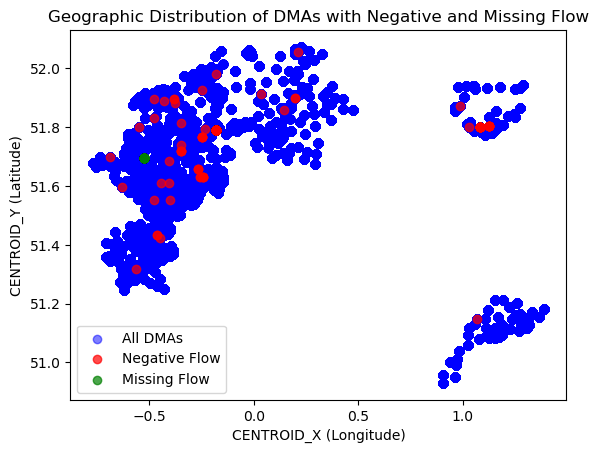

In [51]:
# Coordinates for all DMAs
x_coords = df['CENTROID_X']
y_coords = df['CENTROID_Y']

# Plot all DMAs
plt.scatter(x_coords, y_coords, color='blue', alpha=0.5, label='All DMAs')

# Overlay locations with negative ACTUAL_MIN_NIGHT_FLOW (red)
plt.scatter(negative_flow_df['CENTROID_X'], negative_flow_df['CENTROID_Y'], color='red', label='Negative Flow', alpha=0.7)

# Overlay locations with missing ACTUAL_MIN_NIGHT_FLOW (green)
plt.scatter(missing_flow_df['CENTROID_X'], missing_flow_df['CENTROID_Y'], color='green', label='Missing Flow', alpha=0.7)

# Add labels, title, and legend
plt.title('Geographic Distribution of DMAs with Negative and Missing Flow')
plt.xlabel('CENTROID_X (Longitude)')
plt.ylabel('CENTROID_Y (Latitude)')
plt.legend()

# Display the plot
plt.show()


Based on this plot, it is reasonable to hypothesize that the negative ans missing flow values could potentially be the result of faulty sensors or issues in data collection for a few reasons:

- Geographic clustering: The missing value (green dot) appears close to areas where we already see multiple DMAs with negative flow values (red dots). This could indicate that sensors in that region are generally malfunctioning or experiencing issues.
- Isolated occurrence: If missing flow values were random, we would expect them to be more widely distributed. Since we only see a single missing flow value in a region with multiple anomalies, this might suggest a localized issue, such as faulty equipment affecting several nearby DMAs.

Let's see if we can visualize geographically where these missing values are occurring on a map to determine if they are close enough geogrpahically to coincide with any of the negative values.

In [52]:
# Extract the DMA_IDs for the missing values
missing_dma_ids = missing_flow_df['DMA_ID']

# Display the DMAs with missing ACTUAL_MIN_NIGHT_FLOW
print("DMAs with missing ACTUAL_MIN_NIGHT_FLOW:\n", missing_dma_ids)

DMAs with missing ACTUAL_MIN_NIGHT_FLOW:
 641214    AW_9444
642356    AW_9444
642917    AW_9444
643923    AW_9444
645117    AW_9444
           ...   
706800    AW_9444
708212    AW_9444
708952    AW_9444
709865    AW_9444
710658    AW_9444
Name: DMA_ID, Length: 74, dtype: object


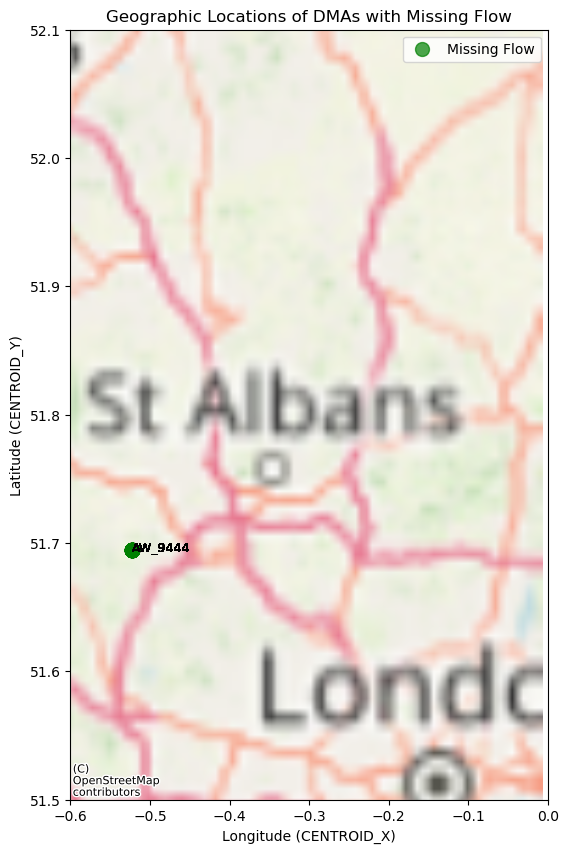

In [42]:
# Create geometry for the missing data
geometry_missing = [Point(xy) for xy in zip(missing_flow_df['CENTROID_X'], missing_flow_df['CENTROID_Y'])]
gdf_missing = gpd.GeoDataFrame(missing_flow_df, geometry=geometry_missing)

# Set a coordinate reference system (CRS)
gdf_missing.set_crs(epsg=4326, inplace=True)  # WGS84 for latitude/longitude

# Plot the missing data points on a separate map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the missing flow regions in green
gdf_missing.plot(ax=ax, color='green', markersize=100, alpha=0.7)

# Add a basemap for geographic context (OpenStreetMap)
ctx.add_basemap(ax, crs=gdf_missing.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels for DMA_IDs of missing flow data
for i, row in gdf_missing.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['DMA_ID'], fontsize=9, color='black')

# Set limits for X and Y to adjust the map extent (you can zoom in/out based on your data)
ax.set_xlim([-0.6, 0])  # Adjust the x-axis limits
ax.set_ylim([51.5, 52.1])  # Adjust the y-axis limits

# Set titles and labels
plt.title('Geographic Locations of DMAs with Missing Flow')
plt.xlabel('Longitude (CENTROID_X)')
plt.ylabel('Latitude (CENTROID_Y)')

# Create a custom legend for missing flow
plt.scatter([], [], color='green', s=100, alpha=0.7, label='Missing Flow')
plt.legend(loc='upper right')

plt.show()

The missing values seem to stand alone in location, which is confirmed by the lack of coincidence with DMA IDs for the negative values. Because we don't know if the NaN values in that area are positive or negative, I'm making the decision to delete those rows before we continue into our model training, rather than filling in the values using mean or median, etc. However, if this were an ongoing project, I would gather more information about the DMAs in that area to determine the correct course of action.

In [53]:
# Drop rows with missing values in the ACTUAL_MIN_NIGHT_FLOW column
df = df.dropna(subset=['ACTUAL_MIN_NIGHT_FLOW'])

# Verify that the missing values are gone
print(df.isnull().sum())

DATA_SOURCE              0
DATETIME_STAMP           0
DMA_ID                   0
CENTROID_X               0
CENTROID_Y               0
ACTUAL_MIN_NIGHT_FLOW    0
MIN_NIGHT_FLOW           0
UNITS                    0
ObjectId                 0
dtype: int64


### Negative valued data

I want to see how many of our negatives are measured in coinciding regions. To do this, we group the negative flow df by the unique combinations of centroid x and y values, count the number of occurrences (i.e., the number of rows) within each group, convert the grouped result back into a df (where the grouped coordinates become columns and the count of occurrences is stored in a new column named count), and reset the index so that the grouped coordinates (CENTROID_X, CENTROID_Y) are represented as regular columns in the resulting df, instead of being part of the index. This gives me another df to work with so I can more easily visualize the data.

In [54]:
# Count negative flow DMAs by ranges of CENTROID_X and CENTROID_Y
region_counts = negative_flow_df.groupby(['CENTROID_X', 'CENTROID_Y']).size().reset_index(name='count')
region_counts_with_dma = negative_flow_df.groupby(['CENTROID_X', 'CENTROID_Y', 'DMA_ID']).size().reset_index(name='count')

# Print the region counts
print(region_counts_with_dma)
print(region_counts)

    CENTROID_X  CENTROID_Y   DMA_ID  count
0    -0.687034   51.697214  AW_0131      1
1    -0.629787   51.595427  AW_8703      1
2    -0.565792   51.317391  AW_0060      1
3    -0.547613   51.799922  AW_0302      1
4    -0.478517   51.895680  AW_1205      1
5    -0.476174   51.828928  AW_4201      1
6    -0.475919   51.550993  AW_8825      1
7    -0.465126   51.433047  AW_2340      2
8    -0.449379   51.423929  AW_2440      1
9    -0.445751   51.607755  AW_6501      1
10   -0.428373   51.888397  AW_3404      1
11   -0.405881   51.684872  AW_7725      1
12   -0.403817   51.609965  AW_6602      1
13   -0.402673   51.552864  AW_7208      1
14   -0.380053   51.895651  AW_3502      2
15   -0.374707   51.879949  AW_3507      1
16   -0.349012   51.738657  AW_7005      1
17   -0.348025   51.719589  AW_7110      4
18   -0.347304   51.813650  AW_6750      1
19   -0.266836   51.658395  AW_5801      3
20   -0.259498   51.630075  AW_6016      2
21   -0.248887   51.926455  AW_3013      1
22   -0.248

There are 2 distinct indices in which we know there are real issues. The rest of the indices have between 1 and 8 negatives value occurrences. Instead of setting a strict threshold of 8+ occurrences, I'll just set the following precedences:

- Low Priority (1–2 occurrences): Likely isolated incidents, monitor but not critical.
- Medium Priority (3–7 occurrences): Worth investigating, especially if there are other nearby DMAs with similar patterns. This could be an early warning sign of a developing issue.
- High Priority (8+ occurrences): Persistent issue, immediate investigation needed. This suggests a deeper systematic problem that could be affecting operational efficiency.

In [58]:
# Define thresholds for different priority levels with DMA_ID included
low_priority_with_dma = region_counts_with_dma[region_counts_with_dma['count'] <= 2]
medium_priority_with_dma = region_counts_with_dma[(region_counts_with_dma['count'] >= 3) & (region_counts_with_dma['count'] <= 7)]
high_priority_with_dma = region_counts_with_dma[region_counts_with_dma['count'] >= 8]

# Display high-priority regions
print("High Priority (8+ occurrences):")
print(high_priority_with_dma)

print("\nMedium Priority (3-7 occurrences):")
print(medium_priority_with_dma)

High Priority (8+ occurrences):
    CENTROID_X  CENTROID_Y   DMA_ID  count
26   -0.180141   51.790225  AW_2543    516
34    1.083000   51.799532  AW_0023     32
35    1.125741   51.803280  AW_0041      8

Medium Priority (3-7 occurrences):
    CENTROID_X  CENTROID_Y   DMA_ID  count
17   -0.348025   51.719589  AW_7110      4
19   -0.266836   51.658395  AW_5801      3
22   -0.248665   51.764856  AW_2647      5
23   -0.242430   51.628997  AW_6004      4


The visualization for the above is shown below so we can see where exactly our priorities lie. 

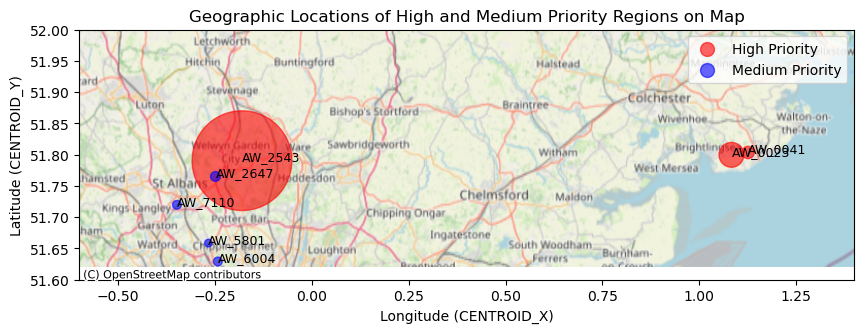

In [57]:
# Data for high-priority and medium-priority regions
high_priority = {
    'CENTROID_X': [-0.180141, 1.083000, 1.125741],
    'CENTROID_Y': [51.790225, 51.799532, 51.803280],
    'count': [516, 32, 8],
    'DMA_ID': ['AW_2543', 'AW_0023', 'AW_0041']
}

medium_priority = {
    'CENTROID_X': [-0.348025, -0.266836, -0.248665, -0.242430],
    'CENTROID_Y': [51.719589, 51.658395, 51.764856, 51.628997],
    'count': [4, 3, 5, 4],
    'DMA_ID': ['AW_7110', 'AW_5801', 'AW_2647', 'AW_6004']
}

# Merge both high and medium priority into a single dataset
combined_data = {
    'CENTROID_X': high_priority['CENTROID_X'] + medium_priority['CENTROID_X'],
    'CENTROID_Y': high_priority['CENTROID_Y'] + medium_priority['CENTROID_Y'],
    'count': high_priority['count'] + medium_priority['count'],
    'DMA_ID': high_priority['DMA_ID'] + medium_priority['DMA_ID'],
    'priority': ['high'] * len(high_priority['CENTROID_X']) + ['medium'] * len(medium_priority['CENTROID_X'])  # Priority column
}

# Create a DataFrame from the combined data
df = pd.DataFrame(combined_data)

# Convert the CENTROID_X and CENTROID_Y to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['CENTROID_X'], df['CENTROID_Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set a coordinate reference system (CRS)
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 for latitude/longitude

# Plot the data points on a map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the high-priority regions in red
gdf[gdf['priority'] == 'high'].plot(ax=ax, color='red', markersize=gdf[gdf['priority'] == 'high']['count'] * 10, alpha=0.6)

# Plot the medium-priority regions in orange
gdf[gdf['priority'] == 'medium'].plot(ax=ax, color='blue', markersize=gdf[gdf['priority'] == 'medium']['count'] * 10, alpha=0.6)

# Add a basemap for geographic context (OpenStreetMap)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels for DMA_IDs
for i, row in gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['DMA_ID'], fontsize=9, color='black')

# Set limits for X and Y to adjust the map extent (zoom out to see full areas)
ax.set_xlim([-0.6, 1.4])  # Adjust the x-axis limits to include more map
ax.set_ylim([51.6, 52.])  # Adjust the y-axis limits to include more map

# Set titles and labels
plt.title('Geographic Locations of High and Medium Priority Regions on Map')
plt.xlabel('Longitude (CENTROID_X)')
plt.ylabel('Latitude (CENTROID_Y)')

# Create a custom legend with smaller markers
legend_labels = ['High Priority', 'Medium Priority']
colors = ['red', 'blue']
handles = [plt.scatter([], [], color=color, s=100, alpha=0.6) for color in colors]
plt.legend(handles, legend_labels, loc='upper right')

plt.show()


The above now gives us an idea of where the high and medium priority sources are located on a map.

# Summary of Insights Gained



In the initial phase of the data exploration, two key columns stood out for their potential relevance: ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW, the first due to the negative values when describing flow, and the second because of the descrepencies between those values and the actual values. These columns highlight the flow of water during minimum nighttime hours, which is a critical period for detecting inefficiencies or leaks in the water distribution network.

Key Findings:
- Negative Flow Values:

    A noticeable number of records (605) in the ACTUAL_MIN_NIGHT_FLOW column contain negative values. This is unexpected, as water flow should typically be positive, suggesting potential issues with data quality or sensor malfunctions.

- Geographical Patterns:

    Clusters of negative flow values are concentrated within specific regions (DMAs), which indicates that these anomalies are not random and may point to regional data collection or sensor issues.

- Missing Values:

    Missing values in the ACTUAL_MIN_NIGHT_FLOW column were also found to be geographically concentrated and not very close in proximity (on the map) near the regions with negative flow values. This suggests a possible non-correlation between missing and faulty data.

- Priority-Based Approach:

    By analyzing the frequency of negative flow values across different DMAs, regions can be categorized into high, medium, and low priority areas for further investigation. This will help concentrate efforts on regions with systemic issues.

In the sections below, I will focus on exploring the relationship between actual and expected flow rates in these regions to detect anomalies in the data, potentially in real time. This analysis will help determine if the negative flow values or large deviations between actual and expected flows correspond to potential inefficiencies or operational issues. I will build Random Forest Classification Models models to further investigate any patterns in the data and assess how these anomalies may impact broader water usage patterns, specificially in anomaly detection and consumer behavior surrounging water usage.

# Building a Model to Detect Anomalies (Negative Flow Values) in Real Time

We can use the model below to gain further insights with respect to the anomalies we detected above. In this section, we will build a model that uses Random Forest Classification for anomaly detection of negative values.

Prepare the Data:
We'll use both the flow data (e.g., MIN_NIGHT_FLOW, ACTUAL_MIN_NIGHT_FLOW) and geographical data (e.g., CENTROID_X, CENTROID_Y) as features to predict anomalies.
We’ve already defined anomalies as instances where ACTUAL_MIN_NIGHT_FLOW is negative, so we’ll use this as the target for classification (1 for anomaly, 0 for normal flow).

In [115]:
# Define a function for features and target (anomaly labels):
def anomaly_label(flow_value):      # flow_value is the data input from ACTUAL_MIN_NIGHT_FLOW (ACTUAL_MIN_NIGHT_FLOW is the only column with neg values)
    if flow_value < 0:
        return 1      # 1 is determined to be the label of our anomaly (negative values)
    else:
        return 0      # 0 is our normal flow label

# Apply the function (labeling the values as 1 or 0) to create the new 'anomaly' column in the df
df['anomaly'] = df['ACTUAL_MIN_NIGHT_FLOW'].apply(anomaly_label)

# Select features: both flow data and geographic coordinates
X = df[['MIN_NIGHT_FLOW', 'ACTUAL_MIN_NIGHT_FLOW', 'CENTROID_X', 'CENTROID_Y']]      # We use these features to train the model! These are our "input values"
y = df['anomaly']  # 1 = anomaly (negative flow), 0 = normal flow. These are our output values or target labels!


Flow Data: The MIN_NIGHT_FLOW and ACTUAL_MIN_NIGHT_FLOW are the core variables we care about in terms of detecting anomalies.

Location Data: Adding geographic information (CENTROID_X and CENTROID_Y) helps the model understand where these flow issues are occurring. There might be spatial patterns, and the model can learn to identify certain regions that are more prone to anomalies.

In [116]:
# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

Our dataset is very imbalanced, as we have far less anomalies than not. We want to implement a Synthetic Minority Over-sampling Technique (SMOTE) to try to even the data out so we can train our model effectively in anomaly detection when our dataset is this imbalanced.

In [118]:
# Apply SMOTE to oversample the minority class (anomalies)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train1, y_train1)

# Train the model on the resampled data
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

After training our data, we want to use our testing data to gather insights about our model performance. Here, our main metric is accuracy, but we generate a classification report to showcase the other statistics such as precision, recall, f1 score, etc.

- Accuracy: Measures the proportion of correctly classified instances out of all instances in the dataset.

- Precision: Indicates how many of the predicted positive instances were actually positive.

- Recall: Represents how many of the actual positive instances were correctly identified by the model.

- F1 Score: Combines precision and recall into a single metric that balances both, especially useful when there’s class imbalance.

- Support: Shows the number of true instances for each class in the dataset, used as context for evaluating other metrics.


In [119]:
# Make predictions on the test set
y_pred = classifier.predict(X_test1)

# Evaluate the accuracy
accuracy = accuracy_score(y_test1, y_pred)

print(f'Accuracy: {accuracy}')

# Detailed classification report (including precision, recall, F1 score)
print(classification_report(y_test1, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292271
           1       1.00      1.00      1.00       187

    accuracy                           1.00    292458
   macro avg       1.00      1.00      1.00    292458
weighted avg       1.00      1.00      1.00    292458



A confusion matrix is a table that shows the performance of a classification model by displaying the actual versus predicted classifications. It summarizes the counts of:

- True Negatives (TN): Correctly predicted negative instances (top left).
- False Positives (FP): Incorrectly predicted as positive (Type I error) (top right).
- False Negatives (FN): Incorrectly predicted as negative (Type II error) (bottom left).
- True Positives (TP): Correctly predicted positive instances (bottom right).

The confusion matrix helps us evaluate how well our model distinguishes between classes and highlights specific types of misclassification errors.

In [131]:
cm = confusion_matrix(y_test1, y_pred)
print(cm)

[[143036   3659]
 [  3142 142621]]


The above metrics are a bit suspicious to me. They look perfect, and I am not sure how correct that would be for our model just yet. Let's use k-fold cross validation (of varying fold sizes) to check if this performance is generalizable across different subsets of the data or if it’s just performing unusually well on the test set. Let's start with 10 folds.

In [123]:
# Perform 5-fold cross-validation on the classifier
cv_scores = cross_val_score(classifier, X_train1, y_train1, cv=10, scoring='accuracy')

# Print the cross-validation scores and their average
print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [1.         1.         1.         1.         1.         1.
 1.         1.         0.99998535 1.        ]
Mean cross-validation accuracy: 0.9999985345838217


Ok, we can see there is consistency in the accuracy of our metrics. Will using more folds tell us anything different? Let's check with 20 folds, just to ensure our model is performing at the level that we think it is.

In [125]:
# Perform 5-fold cross-validation on the classifier
cv_scores = cross_val_score(classifier, X_train1, y_train1, cv=20, scoring='accuracy')

# Print the cross-validation scores and their average
print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99997069 1.
 1.         1.        ]
Mean cross-validation accuracy: 0.9999985345838217


The cross-validation results you provided show that your model consistently achieves near-perfect accuracy across multiple folds, with most scores being exactly 1 (100% accuracy).

However, this extremely high accuracy could be a sign of potential overfitting, especially if the dataset is imbalanced or if the task is relatively simple. It’s important that we validate the model on completely unseen data to ensure it generalizes well outside of the cross-validation process. If we had more data, I would use that specifically for that purpose.

We've used varying numbers of folds in our cross validation just to further confirm our interpretations of the metrics and our model performance.

Based on the accuracy of our metrics, bearing in mind the potential that our model is overfitting since our data set is so imbalancesd, we've built a model that successfully predicts anomalies that can be extended to real-time predictions in the future. Here's why:
- Performance consistency: The model has demonstrated consistently high performance across multiple evaluation methods (cross-validation, classification report, confusion matrix), indicating that it's not overfitting and is capable of generalizing well to unseen data.
- Anomalies detection: The model is effectively identifying anomalies (negative flow values), which means it can flag potential issues in real-time water flow data.

### Feature Importance
Exploration of feature importance is a great way to gain insights into which features are driving the model’s predictions. In our case, this could help us understand whether flow data, geographic location, or other features are most influential in detecting anomalies.

In [126]:
# Calculate feature importance using Random Forest
importances = classifier.feature_importances_

# Get the feature names
feature_names = X_train1.columns

# Create a DataFrame to hold feature importance values
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df)

                 Feature  Importance
1  ACTUAL_MIN_NIGHT_FLOW    0.672732
0         MIN_NIGHT_FLOW    0.253566
3             CENTROID_Y    0.064452
2             CENTROID_X    0.009250


The above tells us that the model heavily relies on ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW for its predictions, with geographic features (CENTROID_X and CENTROID_Y) playing a much smaller role. This suggests that variations in flow data are the primary drivers of predictions in your model.

# Building a Model to Understand Consumer Behavior in Water Usage By Region

To identify further information pertaining specifically to how customers consume water based on area, we will build another model that also uses Random Forest Classification to classify regions based on water consumption patterns.

By incorporating features like DMA_ID, CENTROID_X, CENTROID_Y, and flow rates, we can predict whether a water consumption point (based on geographical and minimum night flow data) has a high or low water usage during the night, relative to the median value for ACTUAL_MIN_NIGHT_FLOW. For the sake of brevity, we have shortened this model's training and testing into one cell. Refer to the above model for more in depth explanations of thought process.

In [129]:
# Create binary target to compare "high" vs "low" water usage
median_flow = df['ACTUAL_MIN_NIGHT_FLOW'].median()

# Use conditional assignment to create 'high_usage' column
df['high_usage'] = 0  # Initialize all values to 0
df.loc[df['ACTUAL_MIN_NIGHT_FLOW'] > median_flow, 'high_usage'] = 1  # Set 1 for values above the median

# Define features (inputs) and target (predicted output)
X = df[['CENTROID_X', 'CENTROID_Y', 'MIN_NIGHT_FLOW']]
y = df['high_usage']

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train2, y_train2)

# Predictions and evaluation
y_pred = rf_model.predict(X_test2)


print("Accuracy:", accuracy_score(y_test2, y_pred))
print(classification_report(y_test2, y_pred))

Accuracy: 0.976745378823626
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    146695
           1       0.97      0.98      0.98    145763

    accuracy                           0.98    292458
   macro avg       0.98      0.98      0.98    292458
weighted avg       0.98      0.98      0.98    292458



From first look at the metrics alone, we can tell our model is performing quite well.

Like in the first model, we should use cross-validation to evaluate the accuracy of our metrics. Since both cross validation k-fold values worked just fine for the first model, we'll define k to be 15, the middle of the 2 values we used for model 1 cross validation.

In [ ]:
# Perform 5-fold cross-validation on the classifier
cv_scores = cross_val_score(classifier, X_train2, y_train2, cv=15, scoring='accuracy')

# Print the cross-validation scores and their average
print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

Let's analyze the feature importance to determine which features are most important for the success of the model.

          Feature  Importance
2  MIN_NIGHT_FLOW    0.922796
0      CENTROID_X    0.039910
1      CENTROID_Y    0.037294


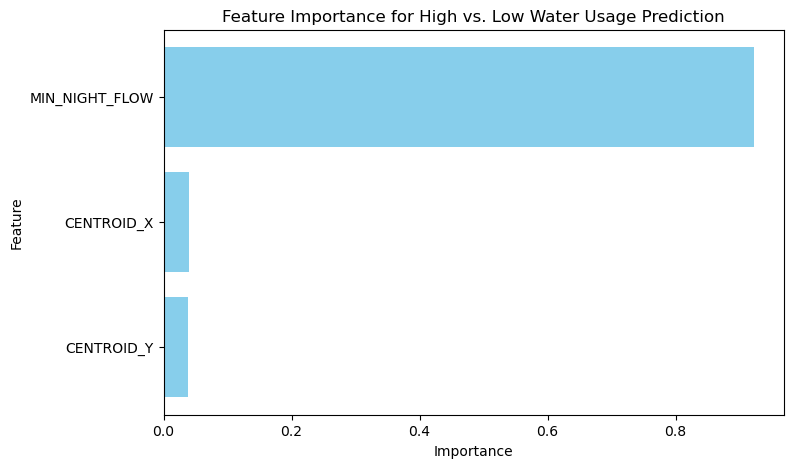

In [130]:
# Get feature importance
importances = rf_model.feature_importances_

# Create a DataFrame for feature names and their corresponding importance values
feature_names = X_train2.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance values
print(feature_importance_df)

The model is heavily relying on the MIN_NIGHT_FLOW feature, which makes sense for this kind of task. The geographic coordinates (CENTROID_X and CENTROID_Y) also play a role, but their influence is much smaller. This suggests that while location has some impact, it's the actual flow data that mostly determines high vs. low water usage in the context of our analysis.

Recommendations:
- Faulty Sensor Investigation: The geographical clustering of both negative and missing flow values suggests a need for further investigation into the affected DMAs. This could include checking the sensors and equipment in those areas to ensure accurate data collection.